## Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.ensemble import RandomForestClassifier
sys.path.append('../src')

from lib_aux import *

In [26]:
from custom_feature_selector import CustomFeatureSelector
from distribution_agent import DistributionAgent

## Leitura do DataFrame

In [27]:
df = pd.read_parquet("../data/SOT/base_tratada_treino.parquet")
df.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_54,VAR_57,VAR_59,VAR_65,VAR_66,VAR_67,VAR_72,VAR_74,VAR_76,VAR_77
0,1.0,201404,0,-0.727634,-0.306095,-0.342735,-0.482881,0.673819,0.278301,-0.213637,...,-0.809742,-0.064927,-0.943633,0.143174,-0.685373,0.142450,-0.014629,2.354360,-0.525657,-0.433522
1,2.0,201407,0,0.627340,-0.306095,2.017805,0.336321,-0.566411,0.150841,0.541208,...,0.175248,1.107199,-0.932521,0.284367,0.800071,0.198180,0.107461,-0.270421,-0.499363,0.272032
2,3.0,201405,0,1.368341,1.278230,2.017805,1.155524,-0.040989,0.056239,-0.798100,...,0.105216,-1.158910,0.066244,-0.246443,0.243029,0.209016,-0.201156,-0.270421,0.738035,1.160245
3,5.0,201403,1,-0.727634,-0.306095,-0.342735,-0.482881,-0.201561,-0.155736,-0.473936,...,0.796639,-0.611919,-0.224547,0.262330,-0.221172,-0.486060,-0.272375,-0.270421,-0.244562,-0.433522
4,6.0,201405,0,0.563826,-0.306095,4.378344,0.336321,-0.234582,-0.201127,-0.493764,...,-0.612744,-1.002627,-0.176851,-0.563487,-0.221172,0.209016,-0.509773,-0.270421,-0.226272,-0.433522


## Distribuição da variável resposta

In [28]:
df["y"].value_counts()

y
0    6453
1    2535
Name: count, dtype: int64

In [29]:
df["y"].value_counts(normalize=True)

y
0    0.717957
1    0.282043
Name: proportion, dtype: float64

In [30]:
df.groupby("safra")["y"].value_counts(normalize=True).sort_index(ascending = False).unstack()

y,0,1
safra,,
201401,0.650775,0.349225
201402,0.687144,0.312856
201403,0.749415,0.250585
201404,0.742004,0.257996
201405,0.749220,0.250780
201406,0.737908,0.262092
201407,0.721639,0.278361
201408,0.716981,0.283019
201409,0.697353,0.302647


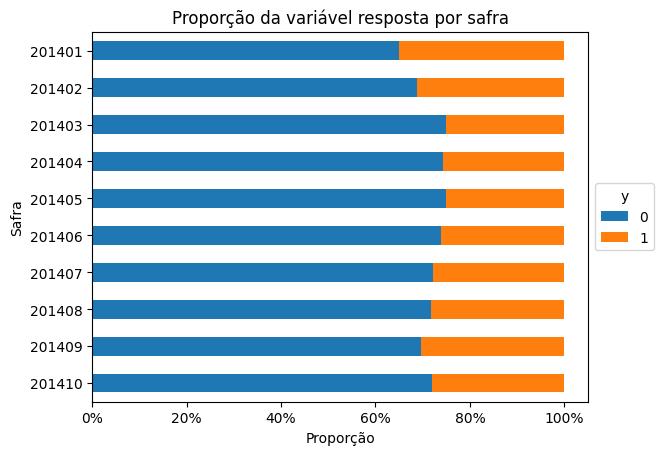

In [31]:
ax = df.groupby("safra")["y"].value_counts(normalize=True).sort_index(ascending=False).unstack().plot(kind="barh", stacked=True)
ax.invert_yaxis()
plt.title("Proporção da variável resposta por safra")
plt.ylabel("Safra")
plt.xlabel("Proporção")
plt.legend(title="y", loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.savefig("../graficos/proporcao_y.png", bbox_inches='tight')
plt.show() ### A proporção da variável resposta não muda drasticamente durante o tempo, mas é importante seguir
               ### monitorando a variável nas próximas safras. Além disso, pela predominância de uma das classes,
                ### é importante considerar a utilização de técnicas de balanceamento de classes.

### Seleção de variáveis por feature importance, para análise das mais importantes

In [32]:
estimator = RandomForestClassifier(n_estimators=100, random_state=98)
seletor = CustomFeatureSelector(estimator, apply_normalization=False, threshold=0.031)
x_train_base = df.drop(columns=["y", "safra", "id"])
y_train_base = df["y"]

In [33]:
x_selecao = seletor.fit_transform(x_train_base, y_train_base) ### Pela feature importance ser muito pequena que divide,
                                                              ### Neste caso a correlação, ainda que pequena, pode servir de filtro
                                                              ### Para as features que serão análisadas
x_selecao[:5]


array([[-0.72763366, -0.34273526,  0.27830071, -0.97967174, -0.27330744,
        -0.06492681,  0.14317408, -0.01462888],
       [ 0.62734009,  2.0178046 ,  0.15084062, -0.22066247,  2.68041173,
         1.10719854,  0.28436706,  0.10746133],
       [ 1.36834137,  2.0178046 ,  0.05623894,  1.1354594 ,  1.24172148,
        -1.15891046, -0.24644331, -0.20115559],
       [-0.72763366, -0.34273526, -0.15573605,  1.29735608, -0.09420518,
        -0.61191863,  0.26232959, -0.27237488],
       [ 0.5638257 ,  4.37834445, -0.20112652, -1.1314736 , -0.13237452,
        -1.00262708, -0.56348719, -0.50977251]])

In [34]:
df.drop(columns=["safra", "id"]).corr()["y"].abs().sort_values(ascending=False)[:7]

y         1.000000
VAR_1     0.374730
VAR_2     0.239627
VAR_3     0.188768
VAR_20    0.170420
VAR_4     0.163198
VAR_32    0.157748
Name: y, dtype: float64

In [35]:
df.drop(columns=["safra", "id"]).corr()["y"].abs().sort_values(ascending=False)[-6:]

VAR_7     0.013980
VAR_53    0.011485
VAR_52    0.007162
VAR_35    0.007040
VAR_15    0.004414
VAR_11    0.003771
Name: y, dtype: float64

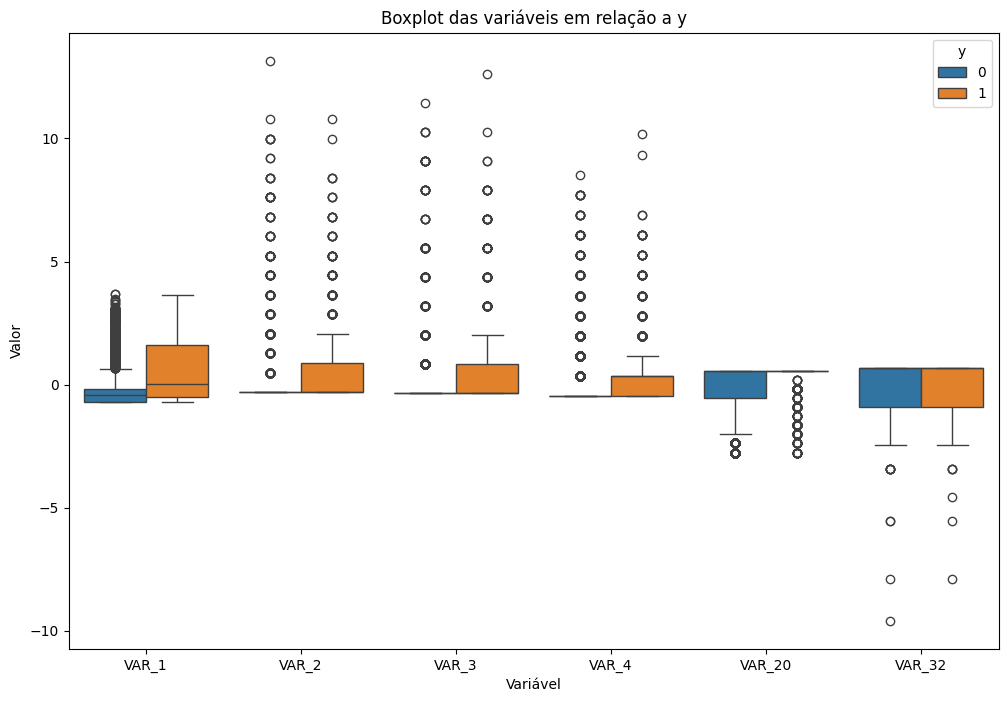

In [36]:
# Selecionar as variáveis de interesse
vars_of_interest = ["VAR_1", "VAR_2", "VAR_3", "VAR_4", "VAR_20", "VAR_32"]

# Criar o boxplot
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars="y", value_vars=vars_of_interest, var_name="Variável", value_name="Valor")
sns.boxplot(x="Variável", y="Valor", hue="y", data=df_melted)
plt.title("Boxplot das variáveis em relação a y")
plt.xlabel("Variável")
plt.ylabel("Valor")
plt.legend(title="y")
plt.show() ### Há diferenças claras entre as classes para as variáveis VAR_1, VAR_2, VAR_3, VAR_4 e VAR_20, enquanto
            ### para a VAR_32, as distribuições são muito parecidas. Isso pode ser um indicativo de que a VAR_32 não
            ### é uma variável tão importante para a classificação

In [37]:
comparador = DistributionAgent(df.drop(columns=["safra", "id"]), "y")
comparador.compare_distributions() ### As variáveis 11, 35 e 52 possuem distribuições iguais.
                                ### Devido à interdependência, considerarei um modelo com e sem elas. Também é importante
                                ### notar que elas possuem menos correlação com a variável resposta

{'VAR_1': np.True_,
 'VAR_2': np.True_,
 'VAR_3': np.True_,
 'VAR_4': np.True_,
 'VAR_5': np.True_,
 'VAR_6': np.True_,
 'VAR_7': np.True_,
 'VAR_8': np.True_,
 'VAR_9': np.True_,
 'VAR_11': np.False_,
 'VAR_14': np.True_,
 'VAR_15': np.True_,
 'VAR_17': np.True_,
 'VAR_19': np.True_,
 'VAR_20': np.True_,
 'VAR_24': np.True_,
 'VAR_27': np.True_,
 'VAR_28': np.True_,
 'VAR_30': np.True_,
 'VAR_31': np.True_,
 'VAR_32': np.True_,
 'VAR_33': np.True_,
 'VAR_34': np.True_,
 'VAR_35': np.False_,
 'VAR_37': np.True_,
 'VAR_38': np.True_,
 'VAR_45': np.True_,
 'VAR_46': np.True_,
 'VAR_51': np.True_,
 'VAR_52': np.False_,
 'VAR_53': np.True_,
 'VAR_54': np.True_,
 'VAR_57': np.True_,
 'VAR_59': np.True_,
 'VAR_65': np.True_,
 'VAR_66': np.True_,
 'VAR_67': np.True_,
 'VAR_72': np.True_,
 'VAR_74': np.True_,
 'VAR_76': np.True_,
 'VAR_77': np.True_}

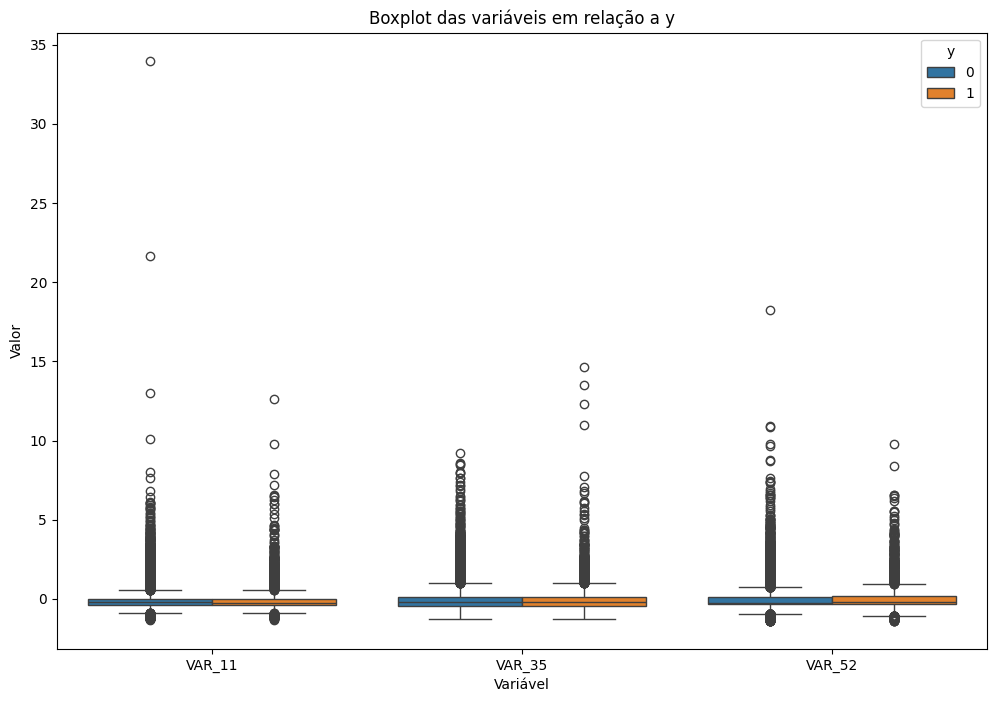

In [38]:
# Selecionar as variáveis de interesse
vars_of_interest = ["VAR_11", "VAR_35", "VAR_52"]

# Criar o boxplot
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars="y", value_vars=vars_of_interest, var_name="Variável", value_name="Valor")
sns.boxplot(x="Variável", y="Valor", hue="y", data=df_melted)
plt.title("Boxplot das variáveis em relação a y")
plt.xlabel("Variável")
plt.ylabel("Valor")
plt.legend(title="y")
plt.show() ### Há diferenças claras entre as classes para as variáveis VAR_1, VAR_2, VAR_3, VAR_4 e VAR_20, enquanto
            ### para a VAR_32, as distribuições são muito parecidas. Isso pode ser um indicativo de que a VAR_32 não
            ### é uma variável tão importante para a classificação

In [39]:
comparador.test_normality() ### Nenhuma variável tem distribuição normal

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8988.
  res = hypotest_fun_out(*samples, **kwds)


{'VAR_1': np.False_,
 'VAR_2': np.False_,
 'VAR_3': np.False_,
 'VAR_4': np.False_,
 'VAR_5': np.False_,
 'VAR_6': np.False_,
 'VAR_7': np.False_,
 'VAR_8': np.False_,
 'VAR_9': np.False_,
 'VAR_11': np.False_,
 'VAR_14': np.False_,
 'VAR_15': np.False_,
 'VAR_17': np.False_,
 'VAR_19': np.False_,
 'VAR_20': np.False_,
 'VAR_24': np.False_,
 'VAR_27': np.False_,
 'VAR_28': np.False_,
 'VAR_30': np.False_,
 'VAR_31': np.False_,
 'VAR_32': np.False_,
 'VAR_33': np.False_,
 'VAR_34': np.False_,
 'VAR_35': np.False_,
 'VAR_37': np.False_,
 'VAR_38': np.False_,
 'VAR_45': np.False_,
 'VAR_46': np.False_,
 'VAR_51': np.False_,
 'VAR_52': np.False_,
 'VAR_53': np.False_,
 'VAR_54': np.False_,
 'VAR_57': np.False_,
 'VAR_59': np.False_,
 'VAR_65': np.False_,
 'VAR_66': np.False_,
 'VAR_67': np.False_,
 'VAR_72': np.False_,
 'VAR_74': np.False_,
 'VAR_76': np.False_,
 'VAR_77': np.False_}

In [40]:
### Contando outliers

df["quantidade_de_outliers"] = comparador.count_outliers().values

In [41]:
df["quantidade_de_outliers"].describe()

count    8988.000000
mean        6.350245
std         4.204273
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        29.000000
Name: quantidade_de_outliers, dtype: float64

In [42]:
outliers = comparador.get_outliers()

In [43]:
outliers

,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,...,VAR_54,VAR_57,VAR_59,VAR_65,VAR_66,VAR_67,VAR_72,VAR_74,VAR_76,VAR_77
11,1,2.808001,4.446880,2.017805,1.155524,-0.156400,0.013141,-0.258250,0.895752,0.538347,...,-0.829593,-0.299352,-0.697747,-0.574003,-0.685373,0.315832,-0.597949,0.604506,0.417963,2.140050
24,0,1.876457,0.486068,-0.342735,-0.482881,2.717722,0.384976,0.754473,2.184609,2.449578,...,0.673673,0.013215,5.788997,3.572932,0.614390,0.198180,-0.513164,-0.270421,5.367871,1.837054
46,1,0.923741,-0.306095,0.837535,0.336321,-0.234582,0.102241,-0.251909,-0.442163,0.538347,...,1.254634,-1.315194,-0.682627,-0.501994,-1.056735,-8.409002,-0.323246,-0.270421,-0.094486,-0.433522
75,0,-0.325376,-0.306095,-0.342735,-0.482881,-0.137138,0.314674,-0.179284,-0.154308,0.538347,...,3.195885,0.638348,-0.122560,0.097768,0.243029,-7.882663,-0.299506,0.604506,-0.329096,-0.055789
105,0,-0.388890,-0.306095,-0.342735,-0.482881,6.948295,0.070146,5.065665,1.389572,0.538347,...,-0.218748,-1.393336,1.888619,-0.164569,0.335869,0.291063,-0.475859,-0.270421,0.589383,-0.433522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8869,0,0.479140,-0.306095,-0.342735,7.709144,1.979444,0.293889,0.087702,1.387281,-0.220662,...,1.488569,0.325782,-0.036048,-0.785626,-0.128332,0.352985,-0.679342,1.479433,0.574687,-0.433522
8893,0,-0.642948,-0.306095,-0.342735,-0.482881,2.687776,-0.121961,1.510701,7.973014,1.297356,...,0.175248,0.403923,0.082430,-0.663747,-0.221172,0.303448,-0.604732,-0.270421,0.296057,-0.433522
8941,0,1.241313,8.407692,0.837535,0.336321,-0.281686,0.050279,0.068796,-0.156599,1.297356,...,0.175248,1.341624,-0.200141,-0.324754,-0.128332,0.198180,2.260997,-0.270421,9.404657,1.690325
8974,1,2.723315,2.070393,0.837535,0.336321,-1.031457,-0.166740,-1.121572,1.062776,2.359969,...,-0.681568,0.091357,-0.224547,-0.634676,-0.221172,0.210564,-0.458902,0.604506,-0.244562,-0.433522


In [44]:
df = df[~(df.index.isin(outliers.index))]

In [45]:
df.to_parquet("../data/SOT/base_tratada_treino_sem_outliers.parquet") ### Salvando a base tratada